In [2]:
!pip install graphlearning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphlearning: filename=graphlearning-1.5.0-cp310-cp310-linux_x86_64.whl size=160278 sha256=40558010574b39a565bff18d658e49244f0dcbc66c69e089829c514c3ee4b2f8
  Stored in directory: /root/.cache/pip/wheels/d5/f4/a2/9e140e097d2232a8375336a8f934e1c67aff2ca2b81346f2de
Successfully built graphlearning


In [107]:
import numpy as np
import numpy.ma as ma
import scipy.integrate as integrate
from scipy.optimize import fsolve
import scipy
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import datasets
import scipy.misc

import graphlearning as gl

import matplotlib.pyplot as plt

import numpy.ma as ma

In [4]:
X, tv = datasets.make_s_curve(n_samples=5000, noise=0, random_state=42)

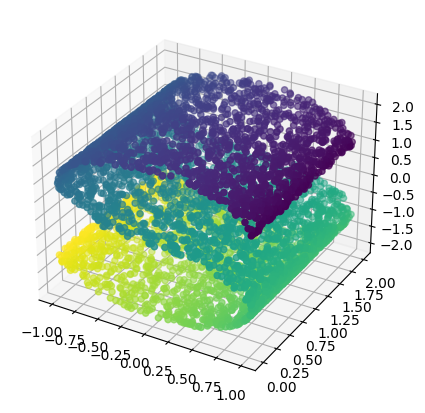

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=tv)
plt.show()

In [6]:
mask = np.zeros(5000, dtype=bool)
label_pts = np.random.choice(np.arange(X[:,0].shape[0]), 1000, replace=False)
mask[label_pts] = True
unlabelled_pts = ~mask
print(mask.sum())
# unlabelled_pts = np.delete(np.arange(X[:,0].shape[0]), label_pts, 0)
unlabelled = X[unlabelled_pts]

# labelled = np.array([[X[label_pts[i], 0], X[label_pts[i], 1], X[label_pts[i], 2]] for i in np.arange(label_pts.shape[0])])
labelled = X[label_pts]
# labelled_tv = np.array([tv[label_pts[i]] for i in np.arange(label_pts.shape[0])])

# unlabelled_tv = np.array([tv[unlabelled_pts[i]] for i in np.arange(unlabelled_pts.shape[0])])

1000


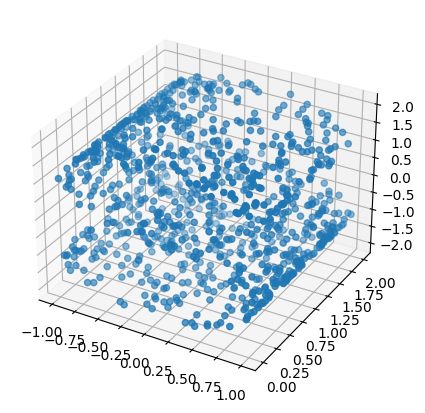

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(labelled[:,0], labelled[:,1], labelled[:,2])
plt.show()

In [95]:
# graph with labelled pts
k_nn = 50 # 200 connected components ensures graph is fully connected; will lead to 1 0 eigenvalue.
h = .3
# W = gl.weightmatrix.knn(labelled, k=k_nn, kernel='gaussian')
W = gl.weightmatrix.knn(labelled, k=k_nn, kernel='distance')
W.data = np.exp(-W.data**2 / h**2)
W = 0.5*W.T+ W
G = gl.graph(W)
D = G.degree_matrix()
L = G.laplacian()
L = L.toarray()

# graph with all pts
# h_w = 0.9
# W_w = gl.weightmatrix.knn(X, k=k_nn_w, kernel='gaussian')
W_w = gl.weightmatrix.knn(X, k=k_nn_w, kernel='distance')

W_w.data = np.exp(-W_w.data**2 / h**2)
W_w = 0.5*W_w.T+ W_w
G_w = gl.graph(W_w)
D_d = G_w.degree_matrix()
L_w = G_w.laplacian()

In [89]:
import scipy
from scipy.spatial.distance import squareform, pdist

In [109]:
W_lul = squareform(pdist(X))
W_lul_ = W_lul[~mask][:,mask]
W_lul_g = np.exp(-W_lul_**2 / h**2)
W_lul_d = W_lul_.sum(axis=1)
D_lul_ = np.diag(W_lul_d)



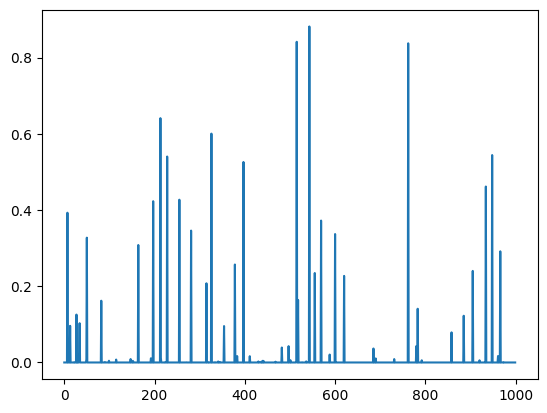

In [110]:
# plt.hist(W_lul_.flatten())
plt.plot(W_lul_g[9,:])

In [12]:
W_w[mask][:,~mask], eigenVectors.shape

NameError: name 'eigenVectors' is not defined

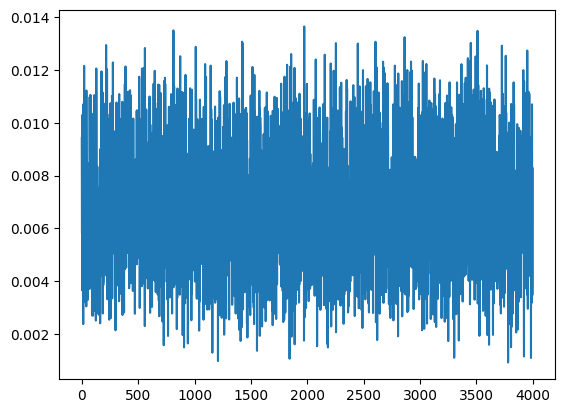

In [113]:
# plt.plot(np.linalg.inv(D_lul_) @ W_lul_g @ np.ones(1000))

In [111]:
eigenValues, eigenVectors = np.linalg.eigh(L)
idx = np.argsort(eigenValues)
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
# print(W_lul[~mask][:,mask].shape)
# only want 2 because we're embedding that in 2d space

# print((np.linalg.inv(D_lul_) @ W_lul_g).sum())
# Y_u = np.linalg.inv(D_lul_) @ W_lul_g @ eigenVectors[:,1:4]

sanity = np.linalg.inv(D_lul_) @ W_lul_g @ X[mask,:]

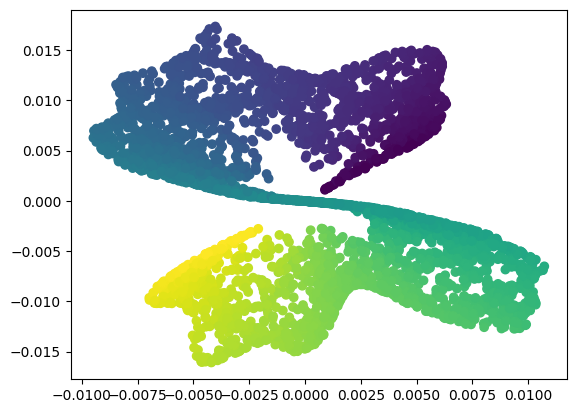

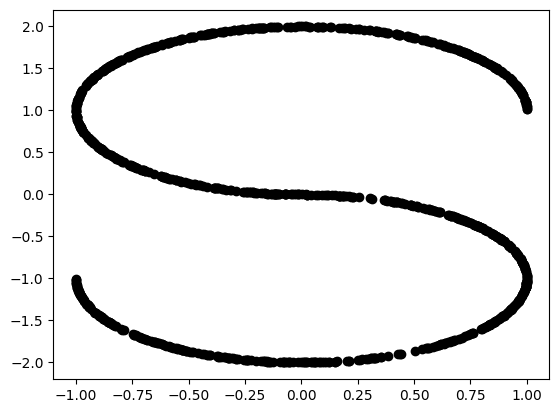

In [112]:
m = 1000
m2 = 4000

r = 9

firstEigenVectors = eigenVectors[:,1:10]

om = np.ones((m,1))
om2 = np.ones((m2,1))

c1 = -firstEigenVectors.T@om

Pconst = np.eye(m2) - 1/m2*np.ones((m2,m2))

C = np.eye(r) - firstEigenVectors.T@firstEigenVectors - 1/m2 * (c1@c1.T)

B = Pconst@(1/m * L_w[~mask][:,~mask]@om2@c1.T +  L_w[~mask][:,mask]@firstEigenVectors)

XtB = Y_u.T@(2*B)
U, s, Vh = np.linalg.svd(XtB, full_matrices=False)
Q = -U@Vh
Y_u = Y_u@Q

Y_u = Y_u + 1/m * om2@c1.T

# plt.scatter(Y_u[:,0], Y_u[:,4], c=tv[~mask])
# plt.scatter(firstEigenVectors[:,0], firstEigenVectors[:,4], c='blue')
# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(projection='3d')
# plt, ax = plt.subplots()
plt.scatter(sanity[:,0], sanity[:,2], c=tv[~mask])
plt.show()
# ax.hold()
plt.scatter(labelled[:,0], labelled[:,2], c='black')

plt.show()

In [ ]:
import jax
from jax import numpy as jnp
from jax import jit, vmap

from jax import config
config.update("jax_enable_x64", True)

In [ ]:
def _sqrtm(C):
    # Computing diagonalization
    evalues, evectors = jnp.linalg.eig(C)
    # Ensuring square root matrix exists
    sqrt_matrix = evectors @ jnp.diag(jnp.sqrt(evalues)) @ jnp.linalg.inv(evectors)
    return sqrt_matrix.real

def nonzero_sorted_eig(A, eps=1e-5):
    w,v = jnp.linalg.eig(A)
    w = w.at[w < eps].set(0)
    sidx = jnp.argsort(w)
    idx = sidx[jnp.in1d(sidx, jnp.flatnonzero(w!=0))]
    return w[idx].real, v[:,idx].real

def stproject(x):
  U_x, _, V_xt = jnp.linalg.svd(x, full_matrices=False)
  return U_x@V_xt

beta=0.9
step_sizes = 1*jnp.power(beta,jnp.linspace(0,100,num=100))

step_sizes = jnp.append(step_sizes,0)
step_sizes=np.array(step_sizes)

In [ ]:
def F(X, A, B, C):
  """Lagrangian - 116 """
  C_sqrt = _sqrtm(C).real
  return  jnp.trace(jnp.dot(X.T, A@X@C)) - 2*jnp.trace(jnp.dot(X.T, B@C_sqrt))

def _value_and_gradF(X, A, B, C):
  """grad F """
  C_sqrt = _sqrtm(C).real

  P = lambda U: X - X@sym(X.T@U)

  return F(X, A, B, C), P(A@X@C-B)
  # return F(X, A, B, C), A@X@C - B@C_sqrt

In [ ]:
def _line_search(s, Gk, Xk, L_, B_, C):
  Xk = stproject(Xk - s*Gk)
  _f_k = F(Xk, L_, B_, C)
  return _f_k, Xk

In [ ]:
Xk = jnp.array(Y_u)

sym = lambda Z: 0.5*(Z@Z.T)

A = L_w[~mask][:,~mask].todense()

for k in range(100):
  Fk, Gk = _value_and_gradF(Xk, L_w[~mask][:,~mask], B, C)

  # line_search(step_sizes,Gk,Xk,Y_u,B,C)
  _Fks, _Xks = vmap(_line_search,in_axes=(0,None,None,None,None,None))(step_sizes,Gk,Xk,A,B,C)

  _f_kamin = jnp.argmin(_Fks)
  _f_k = _Fks[_f_kamin]
  Xk = _Xks[_f_kamin]
  #Xk = stproject(Xk - 0.1*Gk)


  if k % 10 == 0:
    print(Fk)

Xk = Xk + 1/m * om2@c1.T

6.141088039535761e-10
3.1517044666354524e-08
3.151704466635452e-08
3.151704466635453e-08
3.151704466635452e-08
3.1517044666354504e-08
3.1517044666354504e-08
3.1517044666354504e-08
3.1517044666354504e-08
3.1517044666354504e-08


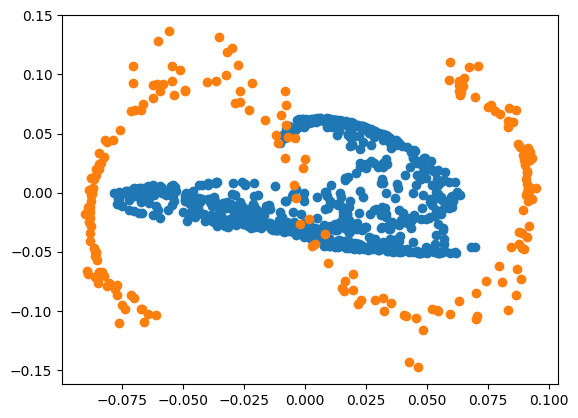

In [ ]:
plt.scatter(Xk[:,0],Xk[:,1])
plt.scatter(firstEigenVectors[:,0],firstEigenVectors[:,1])

plt.show()